In [1]:
!pwd
import netCDF4
import cdsapi

/Users/theoguenais/Desktop/Harvard/Harvard-Classes/hurricast


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from utils import data_processing
from utils import utils_vision_data
import warnings; warnings.simplefilter('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time 

## Get the data

In [4]:
#First we load the storms we are interested to work with
#Storms are begiining at different wind speeds, 
#so to standardize their beginning I cut them at a min_wind threshold they have to pass.
#Some storms don't have a lot of timesteps so you can specify with min_steps the minimum number of timesteps you want
#Some storms are 40 timesteps, others are 120, etc. So I cut them at a certain number of timesteps
min_wind = 50
min_steps = 20
max_steps= 60
data = utils_vision_data.get_storms(min_wind = min_wind, min_steps= min_steps, max_steps=max_steps, extraction=True, path = './data/ibtracs.last3years.list.v04r00.csv')
#y represents the actual target data we are going to use
#y is of shape storms * timesteps * target features
y, _ = data_processing.prepare_tabular_data_vision(min_wind = min_wind, min_steps= min_steps, max_steps=max_steps)
#Then we get their corresponding vision maps
vision_data = utils_vision_data.extract_vision(data, epsilon = 0.05)

The dictionary of storms has been created.
The trajectories have now been padded.
There are 84 storms with 9 features, and maximum number of steps is 60 and minimum is 60.
The tensor has now been created.
The dictionary of storms has been created.
The trajectories have now been padded.
There are 84 storms with 8 features, and maximum number of steps is 60 and minimum is 60.
The tensor has now been created.


In [5]:
#Let's visualize one example of y to understand its format
#y[0] is the timestamp
#y[1] is latitude
#y[2] is longitude
#y[3] is windspeed (intensity)
#y[4] is pressure
#y[5] is the latitude displacement with previous timestep
#y[6] is longitude displacement with previous timestep2
y[0].shape
vision_data[0].shape

(60, 3, 3, 25, 25)

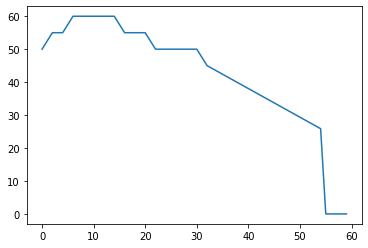

In [6]:
#one important remark: if the number of available timesteps is smaller than a threshold I pad with 0 the end.
#same with the vision data
plt.plot(y[15,:,3])
plt.show()

In [7]:
s = vision_data.shape
print(s)
#s[0] is the storm
#s[1] is the number of timesteps
#s[2] is the value field (geopotential, windspeed u, windspeed v)
#s[3] is the altitude 700, 500, 250
#s[4,5] is the actual map at this timestep, value, and altitude. 1 pixel is 1 degree of latitute and longitude
print("We have {} storms with {} timesteps.".format(s[0], s[1]))

(83, 60, 3, 3, 25, 25)
We have 83 storms with 60 timesteps.


In [39]:
for i in range(vision_data.shape[0]):
    image = torch.tensor(vision_data[i][1])
    print("{}: Number of zeros vs number of total elements: {} vs {}".format(i, torch.sum(image==0), image.numel()))

0: Number of zeros vs number of total elements: 0 vs 5625
1: Number of zeros vs number of total elements: 0 vs 5625
2: Number of zeros vs number of total elements: 0 vs 5625
3: Number of zeros vs number of total elements: 0 vs 5625
4: Number of zeros vs number of total elements: 0 vs 5625
5: Number of zeros vs number of total elements: 0 vs 5625
6: Number of zeros vs number of total elements: 0 vs 5625
7: Number of zeros vs number of total elements: 0 vs 5625
8: Number of zeros vs number of total elements: 0 vs 5625
9: Number of zeros vs number of total elements: 0 vs 5625
10: Number of zeros vs number of total elements: 0 vs 5625
11: Number of zeros vs number of total elements: 0 vs 5625
12: Number of zeros vs number of total elements: 0 vs 5625
13: Number of zeros vs number of total elements: 0 vs 5625
14: Number of zeros vs number of total elements: 0 vs 5625
15: Number of zeros vs number of total elements: 0 vs 5625
16: Number of zeros vs number of total elements: 0 vs 5625
17: Num

In [8]:
%matplotlib notebook 

<IPython.core.display.Javascript object>


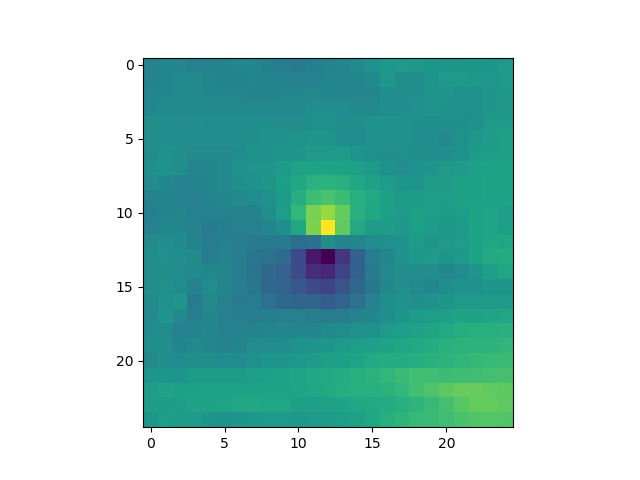

In [11]:
#ani = animate_ouragan(vision_data, 10)
import imp
from utils import plot
imp.reload(plot)
plot.animate_ouragan(vision_data, n=6)

In [12]:
vision_data[0].shape

(60, 3, 3, 25, 25)

## Visualize one map

<IPython.core.display.Javascript object>


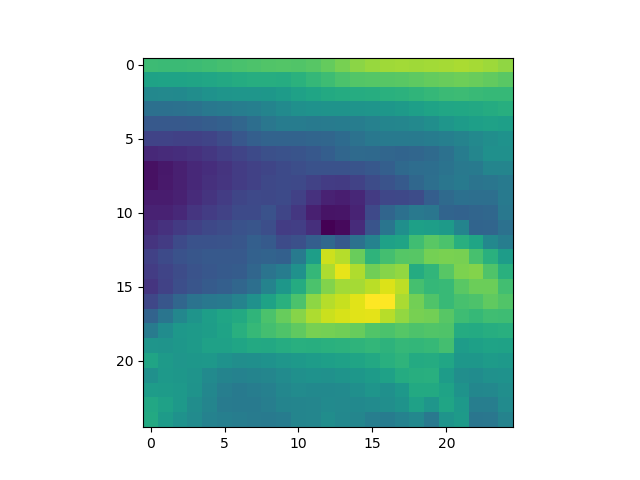

In [13]:
a = vision_data[0, 30, 0, 1]
plt.imshow(a)
plt.show()

In [19]:
#Create Dataset to define a loader with it that will make our lives easier.
import run 
import torch 
train_data = run.HurricaneDS(vision_data, y, predict_at=8)
loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
data_ = next(iter(loader))

Number of elements: 83. Timesteps: 60.        Respective shapes: torch.Size([83, 60, 7]) and torch.Size([83, 60, 3, 3, 25, 25])


In [20]:
for key, value in data_.items():
    print(key, value.size())

X_vision torch.Size([10, 52, 3, 3, 25, 25])
X_stat torch.Size([10, 52, 7])
target_displacement torch.Size([10, 52, 2])
target_velocity torch.Size([10, 52])


In [37]:
l=[]
l.extend([3,2])
print(l)
l.extend([9.4])
print(l)

[3, 2]
[3, 2, 9.4]


In [151]:
hx, hy = torch.randn(batch_size,20), torch.randn(batch_size,2)
init = [hx, hy]
layers = [rnn1, rnn2]
#input_ = (transformed_image, hx)
prev_out = transformed_image
for i, rec in enumerate(layers):
    input_ = (prev_out, init[i])
    prev_out = rec(*input_)


In [141]:
from utils import models
import imp
imp.reload(models)

classic_configuration = (
('conv', 64), 
('conv', 64), 
('maxpool', None),
('conv', 256),
('maxpool', None),
('flatten', 256*4*4),
('linear', 256), 
('fc', 10)
)

mod = models.CNNEncoder(n_in=3*3, 
                n_out = 10, 
                hidden_configuration=classic_configuration)

print(mod)

batch_size = 10
#test_tensor = torch.Tensor(vision_data[:batch_size,:]).resize(batch_size, 9, 25,25)
test_tensor = torch.Tensor(vision_data[:batch_size,:]).resize(batch_size, 60, 9, 25,25).transpose(0,1)
print(test_tensor.size())
#print(mod(test_tensor), mod(test_tensor).size())
rnn1 = nn.GRUCell(10, 20)
rnn2 = nn.GRUCell(20, 2)
#input = torch.randn(6, 3, 10)
#>>> hx = torch.randn(3, 20)
#>>> output = []
#>>> for i in range(6):
#        hx = rnn(input[i], hx)
#        output.append(hx)
hx = torch.randn(batch_size,20)
hy = torch.randn(batch_size,2)
outputs = []
predict_at = 8
for i in range(60):
    test_tensor = torch.Tensor(vision_data[:batch_size,i]).resize(batch_size, 9, 25,25)
    transformed_image = mod(test_tensor)
    hx = rnn1(transformed_image, hx)
    print(transformed_image.size(), hx.size())
    hy = rnn2(hx, hy)
    if i >= predict_at:
        outputs.append(hy)
    
out = torch.stack(outputs).transpose(1,0)
out.size()

CNNEncoder(
  (activation): ReLU()
  (layers): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Flatten()
    (12): Linear(in_features=4096, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=10, bias=True)
  )
)
torch.Size([60, 10,

torch.Size([10, 52, 2])

In [197]:
from utils import models
import imp
imp.reload(models)

classic_configuration = (
('conv', 64), 
('conv', 64), 
('maxpool', None),
('conv', 256),
('maxpool', None),
('flatten', 256*4*4),
('linear', 256), 
('fc', 128)
)

encoder = models.CNNEncoder(n_in=3*3, 
                n_out = 128, 
                hidden_configuration=classic_configuration)

decoder_config = (
('gru', 128),
('gru', 2)
)
encoderdecoder = models.ENCDEC(n_in_decoder=128, 
                               n_out_decoder=2, 
                               encoder=encoder, 
                               hidden_configuration_decoder=decoder_config)

batch_size = 10
test_tensor = torch.Tensor(vision_data[:batch_size]).resize(batch_size, 60, 9, 25,25)
test_tensor.size()
out = encoderdecoder(test_tensor)

In [198]:
out.size() # :)

torch.Size([10, 60, 2])

In [143]:
loss = nn.MSELoss()
print(data_['target_displacement'].size(), out.size())
loss(data_['target_displacement'], out)

torch.Size([10, 52, 2]) torch.Size([10, 52, 2])


tensor(102.7576, grad_fn=<MeanBackward0>)

In [176]:
list(map(
    lambda x: getattr(x, 'hidden_size') ,layers))

[20, 2]

In [33]:
e_d = models.EncoderDecoder(128, 128)
e_d

EncoderDecoder(
  (encoder): EncoderCNNLinear1(
    (cnn): EncoderCNN(
      (conv1): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1))
      (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1))
      (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (linear): EncoderLinear1(
      (fc1): Linear(in_features=4096, out_features=576, bias=True)
      (fc1_bn): BatchNorm1d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc2): Linear(in_features=576, out_features=128, bias=True)
      (fc2_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc3): Linear(in_features=128, out_features=64, bias=True)
      (fc3_

# CNN Encoder

## Test

In [31]:
#To test the model I take one storm and the first timestep.
test = torch.Tensor(vision_data[0,0]).reshape(1, 9, 25, 25)
e_d = EncoderDecoder(128, 128)
e_d.eval()
#Here the model outputs the displacement in x and y respective to the last timestep
e_d(test)

tensor([[[ 0.4193, -0.4846]]], grad_fn=<AddBackward0>)

## ConvLSTM cell

In [38]:
c = ConvLSTM(input_dim = 9, hidden_dim=128, kernel_size=(3,3), num_layers=1, batch_first=True, bias = True)

In [39]:
s = vision_data.shape
v = vision_data.reshape(s[0], s[1], s[2]*s[3], s[4], s[5])
v = torch.Tensor(v)

In [40]:
c.eval()
outputs, last_states = c(v[0][:10].unsqueeze(0))

In [41]:
outputs[0][0].shape

torch.Size([10, 128, 25, 25])